# **Libraries**

In [1]:
# import os
# import shutil
# import numpy as np
# import requests
# import math
# import random
# import datetime
# import pytz

# import xml.etree.ElementTree as ET

# from IPython.display import clear_output

# import torch
# import torchvision
# from torchvision import transforms as T

# from PIL import Image, ImageDraw
# import cv2

In [2]:
from datetime import datetime

In [3]:
import os
import random
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
from torch.utils.data import Dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from skimage import io, transform

# **From previous**

## **Classes**

In [8]:
coco_names =  [
    "person" , "bicycle" , "car" , "motorcycle" , "airplane" , 
    "bus" , "train" , "truck" , "boat" , "traffic light" , # 10 
    "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , 
    "bird" , "cat" , "dog" , "horse" , "sheep" , # 20 
    "cow" , "elephant" , "bear" , "zebra" , "giraffe" , 
    "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , # 30 
    "handbag" , "tie" , "suitcase" , "frisbee" , "skis" , 
    "snowboard" , "sports ball" , "kite" , "baseball bat" , "baseball glove" , # 40 
    "skateboard" , "surfboard" , "tennis racket" , "bottle" , "plate" , 
    "wine glass" , "cup" , "fork" , "knife" , "spoon" , # 50 
    "bowl" , "banana" , "apple" , "sandwich" , "orange" , 
    "broccoli" , "carrot" , "hot dog" , "pizza" , "donut" , # 60 
    "cake" , "chair" , "couch" , "potted plant" , "bed" , 
    "mirror" , "dining table" , "window" , "desk" , "toilet" , # 70 
    "door" , "tv" , "laptop" , "mouse" , "remote" , 
    "keyboard" , "cell phone" , "microwave" , "oven" , "toaster" , # 80 
    "sink" , "refrigerator" , "blender" , "book" , "clock" , 
    "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , # 90 
    "hair brush", # 91 
]

# **Settings**

## gpu/cpu

In [9]:
device = "cpu"
gpus = None
if_multi_gpu_which_gpu = 0

In [10]:
if (torch.cuda.is_available()):
    device = "cuda:0"
    gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
    gpus_props = [torch.cuda.get_device_properties(gpu) for gpu in gpus]
    for ind, gpu in enumerate(gpus_props):
        print ("{:}. {:}".format(ind, gpus[ind]))
        print (" - name:\t\t\t{:}\n - major/minor:\t\t\t{:}/{:}".format(
            gpu.name, gpu.major, gpu.minor,
        ))
        print (" - total_memory:\t\t{:} ({:.2f} GB)\n - Multi-processor count:\t{:}\n".format(
            gpu.total_memory, (gpu.total_memory/1000000000), gpu.multi_processor_count,
        ))
        if (if_multi_gpu_which_gpu == ind):
            device = "cuda:{:}".format(if_multi_gpu_which_gpu)
    print ("*** You are ready to use '{:}' device! ***".format(device))

0. <torch.cuda.device object at 0x7f2ad5e0b280>
 - name:			NVIDIA GeForce RTX 4070 Ti
 - major/minor:			8/9
 - total_memory:		12878086144 (12.88 GB)
 - Multi-processor count:	60

*** You are ready to use 'cuda:0' device! ***


## input-relevant

In [11]:
mapping_csv_index = {
    "images_originals" : 1,
    "images_objects"   : 2,
    "images_depths"    : 3,
    "text_object"      : 4,
}

### object:

In [12]:
object_subfolder = "text_object"
object_index = mapping_csv_index[object_subfolder]

print ("The csv-index for '{:}' is at '{:}'.".format(
    object_subfolder, object_index
))

The csv-index for 'text_object' is at '4'.


In [13]:
ochannels = 5

print ("As you have selected top '{:}' objects as training inputs, number of channels (objects) is set to be '{:}'.".format(
    ochannels, ochannels,
))

As you have selected top '5' objects as training inputs, number of channels (objects) is set to be '5'.


In [14]:
objectspec_input_startindex = 0
objectspec_input_endindex   = 10

objectspec_output_startindex = objectspec_input_endindex
objectspec_output_endindex = 11

### image:

In [15]:
# place the sequence in order
image_options = {
    "color"     : ["images_originals", "images_objects"],
    "grayscale" : ["images_depths"],
}
image_types = [option for option in image_options.keys()]

In [16]:
# configure the image-type and folder here
image_type  = image_types[1]
image_subfolder = image_options[image_type][0]

print ("You selected the following for training:\n - '{:}' images\n - '{:}' folder.".format(
    image_type, image_subfolder,
))

You selected the following for training:
 - 'grayscale' images
 - 'images_depths' folder.


In [17]:
image_index = mapping_csv_index[image_subfolder]

print ("The csv-index for '{:}' is at '{:}'.".format(
    image_subfolder, image_index
))

The csv-index for 'images_depths' is at '3'.


In [18]:
ichannels = 0

if (image_type == image_types[0]): #color
    ichannels = 3
elif (image_type == image_types[1]): #grayscale
    ichannels = 1

print ("As '{:}' images are selected, number of channels (image) is set to be '{:}'.".format(
    image_type, ichannels,
))

As 'grayscale' images are selected, number of channels (image) is set to be '1'.


## outputs

In [19]:
classes = [
    "primary",
    "not-primary",
]

## model definition

In [20]:
iconv1_out_channels = 15
iconv2_out_channels = 30
iconv3_out_channels = 60

oconv1_out_channels = 15
oconv2_out_channels = 30
oconv3_out_channels = 60

In [21]:
ikernel_size_conv  = (3, 3)
istride_conv       = (1, 1)
ikernel_size_pool = (2, 2)
istride_pool      = (2, 2)

okernel_size_conv  = 1
ostride_conv       = 1
okernel_size_pool = 1
ostride_pool      = 1

## training

In [22]:
batch_size = 128
epochs = 27

## output-folders/files

In [23]:
model_out_subfolder = "trained_on_{:}".format(image_subfolder)

In [24]:
model_out_path = "../models/" + model_out_subfolder + "/"

print ("After training, current model will be saved/loaded to/from '{:}' directory.".format(
    model_out_path,
))

After training, current model will be saved/loaded to/from '../models/trained_on_images_depths/' directory.


In [25]:
model_out_file_postfix = "-primenet.pth"

In [26]:
model_out_file_prefix = "" # will be populated based on finsih-datetime

# Functions

In [27]:
def plot_objectspecs(image, objectspec_detail):
    """Show image with object specifications"""
    plt.imshow(image)
    # plt.scatter(objectspec_detail[:, 0], objectspec_detail[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [28]:
def show_objectspecs(image, objectspec_detail):
    """Show object-specs"""
    print ("{:}\n".format(objectspec_detail))

# Our Custom Dataset Class

### **Per record are going to be:**
#### - image
#### - object specifications (objects, 11) - coordinates, class, area, depth, pred_score, primary

In [29]:
class ObjectsDataset(Dataset):
    """Objects dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.main_csv = pd.read_csv(csv_file)
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.main_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.main_csv.iloc[idx, image_index])
        #img_obj_det = os.path.join(self.root_dir, self.main_csv.iloc[idx, 2])
        #img_depth = os.path.join(self.root_dir, self.main_csv.iloc[idx, 3])
        txt_obj = os.path.join(self.root_dir, self.main_csv.iloc[idx, object_index])

        image = io.imread(img_path)
#         if (color_images is True):
#             image = io.imread(img_org)
            
#         elif (color_images is False):
#             image = io.imread(img_depth)

        objectspec = pd.read_csv(txt_obj)

        # specifications
        objectspec_detail = objectspec.iloc[:,objectspec_input_startindex:objectspec_output_endindex]
        objectspec_detail = objectspec_detail.reindex(range(ochannels), fill_value=0)
        objectspec_detail = np.array([objectspec_detail])
        objectspec_detail = objectspec_detail.astype("float").reshape(-1, objectspec_output_endindex)

        sample = {
            "image"             : image,
            "objectspec_detail" : objectspec_detail,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

# *Load the Custom Dataset*

In [30]:
root_dir = ""
custom_annotations = "dataset/custom_annotations.txt"

In [31]:
object_dataset = ObjectsDataset(
    csv_file=custom_annotations,
    root_dir=root_dir,
)

In [32]:
object_dataset.main_csv

,image_id,image_original,image_object_detection,image_depth,text_object
0,0,dataset/images_originals/0-0.jpg,dataset/images_objects/0-0.jpg,dataset/images_depths/0-0.jpg,dataset/texts_objects/0-0.txt
1,1,dataset/images_originals/1-0.jpg,dataset/images_objects/1-0.jpg,dataset/images_depths/1-0.jpg,dataset/texts_objects/1-0.txt
2,2,dataset/images_originals/2-0.jpg,dataset/images_objects/2-0.jpg,dataset/images_depths/2-0.jpg,dataset/texts_objects/2-0.txt
3,3,dataset/images_originals/3-0.jpg,dataset/images_objects/3-0.jpg,dataset/images_depths/3-0.jpg,dataset/texts_objects/3-0.txt
4,4,dataset/images_originals/4-0.jpg,dataset/images_objects/4-0.jpg,dataset/images_depths/4-0.jpg,dataset/texts_objects/4-0.txt
...,...,...,...,...,...
983,983,dataset/images_originals/983-0.jpg,dataset/images_objects/983-0.jpg,dataset/images_depths/983-0.jpg,dataset/texts_objects/983-0.txt
984,984,dataset/images_originals/984-0.jpg,dataset/images_objects/984-0.jpg,dataset/images_depths/984-0.jpg,dataset/texts_objects/984-0.txt
985,985,dataset/images_originals/985-0.jpg,dataset/images_objects/985-0.jpg,dataset/images_depths/985-0.jpg,dataset/texts_objects/985-0.txt
986,986,dataset/images_originals/986-0.jpg,dataset/images_objects/986-0.jpg,dataset/images_depths/986-0.jpg,dataset/texts_objects/986-0.txt


In [33]:
print ("The shapes for image and objectspec_detail are:\n - image: {:}\n - objectspec_detail: {:}".format(
    object_dataset[0]["image"].shape,
    object_dataset[0]["objectspec_detail"].shape,
))

The shapes for image and objectspec_detail are:
 - image: (480, 640)
 - objectspec_detail: (5, 11)


# **Iterate the Custom Dataset**

In [34]:
show_objects_with_object_specs = not True

total_records  = len(object_dataset)
show_n_records = 4
if (show_n_records > 0):
    show_n_records = show_n_records if (show_n_records <= total_records-1) else total_records-1
else:
    show_n_records = 1

# print ("'{:}' record(s) will be shown".format(
#     show_n_records
# )) if (show_n_records > -1) else print("'{:}' records can't be shown".format(
#     show_n_records
# ))

In [35]:
# figsize = (show_n_records*6, show_n_records*5)

for i, sample in enumerate(object_dataset):
    print ("{:}\nImage # {:}".format(
        "**************************************************************************",
        i
    ))
    print (" - image:\t{:}".format(sample["image"].shape))
    print (" - obj-detail:\t{:}".format(sample["objectspec_detail"].shape))
    if (show_objects_with_object_specs):
        show_objectspecs(**sample)

    if (i == (show_n_records-1)):
        break

**************************************************************************
Image # 0
 - image:	(480, 640)
 - obj-detail:	(5, 11)
**************************************************************************
Image # 1
 - image:	(427, 640)
 - obj-detail:	(5, 11)
**************************************************************************
Image # 2
 - image:	(640, 490)
 - obj-detail:	(5, 11)
**************************************************************************
Image # 3
 - image:	(417, 500)
 - obj-detail:	(5, 11)


# **Preprocess the Dataset**

## Classes for Preprocessing

# ************************************************
# IMPROVE THIS PART:
## - Scale before labeling in 1_SSD* notebook
## - Crop the images only if required
## - Update the ToTensor fucntion of this section
# ************************************************

### **1. Rescale**

In [36]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image             = sample["image"]
        objectspec_detail = sample["objectspec_detail"]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {
            "image"             : img,
            "objectspec_detail" : objectspec_detail,
        }

### **2. RandomCrop**

In [37]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image             = sample["image"]
        objectspec_detail = sample["objectspec_detail"]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {
            "image"             : image,
            "objectspec_detail" : objectspec_detail,
        }

### **3. ToTensor**

In [38]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image             = sample["image"]
        objectspec_detail = sample["objectspec_detail"]

        if (ichannels == 3):
            # swap color axis because
            # numpy image: H x W x C
            # torch image: C x H x W
            image = image.transpose((2, 0, 1))
        elif (ichannels == 1):
            # need to add an extra dimension for grayscale images
            image = np.expand_dims(image, axis=0) #equivalent in pytorch: torch.unsqueeze(image, dim=0)
            pass
        return {
            "image"             : torch.from_numpy(image),
            "objectspec_detail" : torch.from_numpy(objectspec_detail),
        }

## **Compose Transforms**

In [39]:
scale_val = 256
crop_val1 = 128
crop_val2 = 256

In [40]:
scale = Rescale(scale_val)
crop = RandomCrop(crop_val1)
composed = transforms.Compose([
    Rescale(scale_val),
    RandomCrop(crop_val2),
])
print ("{:}\n{:}\n\n{:}".format(
    scale,
    crop,
    composed,
))


Compose(
)


In [41]:
sample_num = 3
fig = plt.figure()
sample = object_dataset[sample_num]

<Figure size 640x480 with 0 Axes>

<class '__main__.Rescale'>
(256, 306)


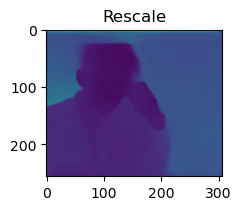

<class '__main__.RandomCrop'>
(128, 128)


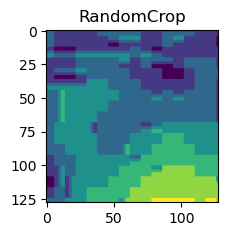

<class 'torchvision.transforms.transforms.Compose'>
(256, 256)


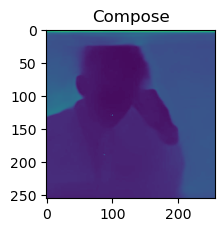

In [42]:
for i, tsfrm in enumerate([scale, crop, composed]):
    print (type(tsfrm))
    transformed_sample = tsfrm(sample)
    print (transformed_sample["image"].shape)
    
    ax = plt.subplot(1, 3, i+1)
    # ax.axis("off")
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plot_objectspecs(**transformed_sample)

In [43]:
print ("The shapes for image and objectspec_detail (after transforming) are:\n - image: {:}\n - objectspec_detail: {:}".format(
    transformed_sample["image"].shape,
    transformed_sample["objectspec_detail"].shape,
))

The shapes for image and objectspec_detail (after transforming) are:
 - image: (256, 256)
 - objectspec_detail: (5, 11)


## **Transform the Dataset and Visualize its Input-size**

In [44]:
transformed_dataset = ObjectsDataset(
    csv_file=custom_annotations,
    root_dir=root_dir,
    transform=transforms.Compose([
        Rescale(scale_val),
        RandomCrop(crop_val2),
        ToTensor()
    ])
)

In [45]:
figsize = (show_n_records*6, show_n_records*5)

for i, sample in enumerate(transformed_dataset):
    print ("{:}\nImage # {:}".format(
        "**************************************************************************",
        i
    ))
    print (" - image:\t{:}".format(sample["image"].shape))
    print (" - obj-detail:\t{:}".format(sample["objectspec_detail"].shape))

    if (i == (show_n_records-1)):
        break

**************************************************************************
Image # 0
 - image:	torch.Size([1, 256, 256])
 - obj-detail:	torch.Size([5, 11])
**************************************************************************
Image # 1
 - image:	torch.Size([1, 256, 256])
 - obj-detail:	torch.Size([5, 11])
**************************************************************************
Image # 2
 - image:	torch.Size([1, 256, 256])
 - obj-detail:	torch.Size([5, 11])
**************************************************************************
Image # 3
 - image:	torch.Size([1, 256, 256])
 - obj-detail:	torch.Size([5, 11])


# **Train / test / validation split and labels**

In [46]:
trainset, valset, testset = torch.utils.data.random_split(
    transformed_dataset,
    [
        0.8,
        0.1,
        0.1,
    ],
)

In [47]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

In [48]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2,
)

# **Define a Multi-label Classification (?)**

## definition

In [49]:
import torch.nn as nn
import torch.nn.functional as F

In [50]:
do_Net = not True

In [51]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        ##### image #####
        self.iconv1 = nn.Conv2d(
            in_channels  = ichannels,
            out_channels = iconv1_out_channels,
            kernel_size  = ikernel_size_conv,
            stride       = istride_conv,
            padding      = "same",
        )
        self.ipool  = nn.MaxPool2d(
            kernel_size = ikernel_size_pool,
            stride      = istride_pool,
        )

        self.iconv2 = nn.Conv2d(
            in_channels  = iconv1_out_channels,
            out_channels = iconv2_out_channels,
            kernel_size  = ikernel_size_conv,
            stride       = istride_conv,
            padding      = "same",
        )

        self.iconv3 = nn.Conv2d(
            in_channels  = iconv2_out_channels,
            out_channels = iconv3_out_channels,
            kernel_size  = ikernel_size_conv,
            stride       = istride_conv,
            padding      = "same",
        )

        self.iglobalavgpool = nn.AdaptiveAvgPool2d((1, 1))

        ##### objectspec #####
        self.oconv1 = nn.Conv1d(
            in_channels  = ochannels,
            out_channels = oconv1_out_channels,
            kernel_size  = okernel_size_conv,
            stride       = ostride_conv,
            # padding      = "same",
        )
        self.opool  = nn.MaxPool1d(
            kernel_size = okernel_size_pool,
            stride      = ostride_pool,
        )

        self.oconv2 = nn.Conv1d(
            in_channels  = oconv1_out_channels,
            out_channels = oconv2_out_channels,
            kernel_size  = okernel_size_conv,
            stride       = ostride_conv,
            # padding      = "same",
        )

        self.oconv3 = nn.Conv1d(
            in_channels  = oconv2_out_channels,
            out_channels = oconv3_out_channels,
            kernel_size  = okernel_size_conv,
            stride       = ostride_conv,
            # padding      = "same",
        )

        self.oglobalavgpool = nn.AdaptiveAvgPool1d(1)

        ##### For both (image and objectspec) #####
        self.fc1   = nn.Linear(
            in_features  = 120,
            out_features = ochannels,
        )
        self.fc2   = nn.Linear(
            in_features  = 7680,
            out_features = 3840,
        )
        self.fc3   = nn.Linear(
            in_features  = 3840,
            out_features = 1920,
        )
        self.fc4   = nn.Linear(
            in_features  = 1920,
            out_features = ochannels,
        )
        # powers of two:
        # 16384, 8192, 4096, 2048, 1024,
        # 512, 256, 128, 64, 32, 16, 8, 4, 2, 1

    def forward(self, image, objectspec):

        ##### image #####
        print ("Image:") if (do_Net) else None
        print (image.shape, "--- image") if (do_Net) else None
        image = F.relu(self.iconv1(image))
        print (image.shape, "--- conv1") if (do_Net) else None
        image = self.ipool(image)
        print (image.shape, "--- pool") if (do_Net) else None
        image = F.relu(self.iconv2(image))
        print (image.shape, "--- conv2") if (do_Net) else None
        image = self.ipool(image)
        print (image.shape, "--- pool") if (do_Net) else None
        image = F.relu(self.iconv3(image))
        print (image.shape, "--- conv3") if (do_Net) else None
        image = self.ipool(image)
        print (image.shape, "--- pool") if (do_Net) else None

        image = self.iglobalavgpool(image)
        print (image.shape, "--- globalavgpool") if (do_Net) else None
        image = image.view(image.shape[0], iconv3_out_channels, -1)
        print (image.shape, "--- view") if (do_Net) else None

        ##### objectspec #####
        print ("\nObject:") if (do_Net) else None
        print (objectspec.shape, "--- objectspec") if (do_Net) else None
        objectspec = F.relu(self.oconv1(objectspec))
        print (objectspec.shape, "--- conv1") if (do_Net) else None
        objectspec = self.opool(objectspec)
        print (objectspec.shape, "--- pool") if (do_Net) else None
        objectspec = F.relu(self.oconv2(objectspec))
        print (objectspec.shape, "--- conv2") if (do_Net) else None
        objectspec = self.opool(objectspec)
        print (objectspec.shape, "--- pool") if (do_Net) else None
        objectspec = F.relu(self.oconv3(objectspec))
        print (objectspec.shape, "--- conv3") if (do_Net) else None
        objectspec = self.opool(objectspec)
        print (objectspec.shape, "--- pool") if (do_Net) else None
        objectspec = self.oglobalavgpool(objectspec)
        print (objectspec.shape, "--- globalavgpool") if (do_Net) else None
        
        ##### For both (image and objectspec) #####
        print ("\nFully connected:") if (do_Net) else None
        print (image.shape, "--- image") if (do_Net) else None
        print (objectspec.shape, "--- objectspec") if (do_Net) else None
        inputfc = torch.cat((image, objectspec), 1)
        print (inputfc.shape, "--- inputfc-after-concat") if (do_Net) else None
        inputfc = torch.squeeze(inputfc, dim=2)
        print (inputfc.shape, "--- inputfc-squeeze") if (do_Net) else None

        inputfc = self.fc1(inputfc)
        print (inputfc.shape, "--- fc1") if (do_Net) else None

        # inputfc = F.relu(self.fc2(inputfc))
        # print (inputfc.shape, "--- fc2") if (do_Net) else None
        # inputfc = F.relu(self.fc3(inputfc))
        # print (inputfc.shape, "--- fc3") if (do_Net) else None
        # inputfc = F.relu(self.fc4(inputfc))
        # print (inputfc.shape, "--- fc4") if (do_Net) else None

        # print ("") if (do_Net) else None

        inputfc = F.sigmoid(inputfc)
        print (inputfc.shape, "--- inputfc-sigmoid") if (do_Net) else None
        print ("\n\n\n*******************************************************\n\n\n") if (do_Net) else None

        return inputfc

In [57]:
net = None

In [60]:
if (ichannels == 3 or ichannels == 1):
    net = Net()
    net = net.to(device)

In [61]:
net.modules

<bound method Module.modules of Net(
  (iconv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ipool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (iconv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iconv3): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iglobalavgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (oconv1): Conv1d(5, 15, kernel_size=(1,), stride=(1,))
  (opool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (oconv2): Conv1d(15, 30, kernel_size=(1,), stride=(1,))
  (oconv3): Conv1d(30, 60, kernel_size=(1,), stride=(1,))
  (oglobalavgpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=120, out_features=5, bias=True)
  (fc2): Linear(in_features=7680, out_features=3840, bias=True)
  (fc3): Linear(in_features=3840, out_features=1920, bias=True)
  (fc4): Linear(in_features=1920, out_features=5, bias=True)
)>

## criterion and optimizer

In [62]:
import torch.optim as optim

In [63]:
learning_rate = 0.000001
momentum = 0.9

In [64]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

# optimizer = optim.Adam(net.parameters(), lr=learning_rate)
optimizer = optim.AdamW(net.parameters(), lr=learning_rate)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

## training

In [65]:
train_started = datetime.now()
print (train_started)

2023-07-20 21:13:28.891621


In [66]:
do_Epochs           = not True
do_Batch            = not True
do_Batch_Final_Only = True

# may change due to do_Batch (bool)
do_Epochs = True if do_Batch else do_Epochs

# may change due to do_Batch_Final_Only (bool)
do_Epochs = True if do_Batch_Final_Only else do_Epochs
do_Batch  = False if do_Batch_Final_Only else do_Batch

In [67]:
for epoch in range(epochs):  # loop over the dataset multiple times
    print ("Epoch: {:} -".format(epoch+1)) if (do_Epochs) else None
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        image, objectspec_detail = data["image"], data["objectspec_detail"]
        objectspec = objectspec_detail[:, :, objectspec_input_startindex:objectspec_output_endindex].float()
        labels = torch.squeeze(objectspec_detail[:, :, objectspec_output_startindex:objectspec_output_endindex].float(), dim=2)
        inputs = image.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device), objectspec.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print("- [Batch # {:}] loss: {:.3f}".format(
            i + 1, running_loss / 2000
        )) if (do_Batch) else None
    print("- [FFF-Batch # {:}] loss: {:.3f}".format(
        i + 1, running_loss / 2000
    )) if (do_Batch_Final_Only) else None

Epoch: 1 -
- [FFF-Batch # 7] loss: 0.108
Epoch: 2 -
- [FFF-Batch # 7] loss: 0.107
Epoch: 3 -
- [FFF-Batch # 7] loss: 0.103
Epoch: 4 -
- [FFF-Batch # 7] loss: 0.100
Epoch: 5 -
- [FFF-Batch # 7] loss: 0.104
Epoch: 6 -
- [FFF-Batch # 7] loss: 0.105
Epoch: 7 -
- [FFF-Batch # 7] loss: 0.108
Epoch: 8 -
- [FFF-Batch # 7] loss: 0.108
Epoch: 9 -
- [FFF-Batch # 7] loss: 0.102
Epoch: 10 -
- [FFF-Batch # 7] loss: 0.104
Epoch: 11 -
- [FFF-Batch # 7] loss: 0.106
Epoch: 12 -
- [FFF-Batch # 7] loss: 0.106
Epoch: 13 -
- [FFF-Batch # 7] loss: 0.107
Epoch: 14 -
- [FFF-Batch # 7] loss: 0.104
Epoch: 15 -
- [FFF-Batch # 7] loss: 0.105
Epoch: 16 -
- [FFF-Batch # 7] loss: 0.105
Epoch: 17 -
- [FFF-Batch # 7] loss: 0.104
Epoch: 18 -
- [FFF-Batch # 7] loss: 0.101
Epoch: 19 -
- [FFF-Batch # 7] loss: 0.105
Epoch: 20 -
- [FFF-Batch # 7] loss: 0.106
Epoch: 21 -
- [FFF-Batch # 7] loss: 0.104
Epoch: 22 -
- [FFF-Batch # 7] loss: 0.106
Epoch: 23 -
- [FFF-Batch # 7] loss: 0.105
Epoch: 24 -
- [FFF-Batch # 7] loss: 0.105
E

In [88]:
image.shape

torch.Size([23, 1, 256, 256])

In [89]:
objectspec_detail.shape

torch.Size([98, 5, 11])

In [90]:
labels.shape

torch.Size([23, 5])

In [68]:
print("Finished Training:\ttotal '{:}' epochs.".format(epoch))

Finished Training:	total '26' epochs.


In [69]:
train_ended = datetime.now()
print (train_ended)

2023-07-20 21:14:22.014974


In [70]:
print ("difference in:")

secs = (train_ended-train_started).total_seconds()
print(" - seconds:\t{:.0f}".format(secs))

hours = secs / (60 * 60)
print(" - hours:\t{:.2f}".format(hours))

mins = secs / 60
print(" - in minutes:\t{:.2f}".format(mins))

hours_f = int(hours)
mins_f = int(mins-hours_f * 60)
secs_f = int(secs - ((hours_f*60*60) + (mins_f*60)))

print ("It took {:} Hour(s), {:} Minute(s), and {:} Seconds to train this model!".format(
    hours_f, mins_f, secs_f,
))

difference in:
 - seconds:	53
 - hours:	0.01
 - in minutes:	0.89
It took 0 Hour(s), 0 Minute(s), and 53 Seconds to train this model!


## save the model

In [71]:
model_out_file_prefix = train_ended.strftime("%Y-%m-%d %H-%M")

In [72]:
model_out_file = model_out_path + model_out_file_prefix + model_out_file_postfix

In [73]:
print ("Going to save the model here: '{:}'".format(model_out_file))

Going to save the model here: '../models/trained_on_images_depths/2023-07-20 21-14-primenet.pth'


In [74]:
torch.save(net.state_dict(), model_out_file)

## evaluation

In [217]:
net.eval()

Net(
  (iconv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ipool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (iconv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iconv3): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iglobalavgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (oconv1): Conv1d(5, 15, kernel_size=(1,), stride=(1,))
  (opool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (oconv2): Conv1d(15, 30, kernel_size=(1,), stride=(1,))
  (oconv3): Conv1d(30, 60, kernel_size=(1,), stride=(1,))
  (oglobalavgpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=120, out_features=5, bias=True)
  (fc2): Linear(in_features=7680, out_features=3840, bias=True)
  (fc3): Linear(in_features=3840, out_features=1920, bias=True)
  (fc4): Linear(in_features=1920, out_features=5, bias=True)
)

### show a sample of evaluation

In [180]:
dataiter = iter(testloader)
samples = next(dataiter)

In [181]:
test_images, objectspec_detail = samples["image"].float(), samples["objectspec_detail"]
test_objectspec_detail = objectspec_detail[:, :, objectspec_input_startindex:objectspec_input_endindex].float()
test_labels = objectspec_detail[:, :, objectspec_output_startindex:objectspec_output_endindex]

In [182]:
with torch.no_grad():
    classifications = net(test_images.to(device), test_objectspec_detail.to(device))
    print ("Classifications: {:}".format(classifications.shape))
    print ("Expections: {:}".format(test_labels.shape))

Classifications: torch.Size([98, 5])
Expections: torch.Size([98, 5, 1])


In [183]:
# random index from samples # if you want to test a specific example replace the randomness.
test_comparison_index = random.randint(0, test_labels.shape[0]-1)
print ("testing sample '{:}'".format(test_comparison_index))

testing sample '77'


In [184]:
precn = ".19f"

cls = [v.item() for v in classifications[test_comparison_index]]
exp = [v.item() for v in test_labels[test_comparison_index]]
err = [abs(cl - ex) for cl, ex in zip(cls, exp)]
err_ttl = sum(err)
err_avg = err_ttl/len(err)

print ("classified : ", ", ".join([format(i, precn) for i in cls]))
print ("expected   : ", ", ".join([format(i, precn) for i in exp]))
print ("error      = ", ", ".join([format(i, precn) for i in err]))
print ("total err: {:}".format(err_ttl))
print ("avrge err: {:}".format(err_avg))

classified :  0.0000000000000000000, 1.0000000000000000000, 0.0000000000000000000, 1.0000000000000000000, 0.0000000000000000000
expected   :  1.0000000000000000000, 1.0000000000000000000, 0.0000000000000000000, 0.0000000000000000000, 0.0000000000000000000
error      =  1.0000000000000000000, 0.0000000000000000000, 0.0000000000000000000, 1.0000000000000000000, 0.0000000000000000000
total err: 2.0
avrge err: 0.4


In [185]:
[v.item() for v in classifications[test_comparison_index]]

[0.0, 1.0, 0.0, 1.0, 0.0]

In [186]:
[v.item() for v in test_labels[test_comparison_index]]

[1.0, 1.0, 0.0, 0.0, 0.0]

### overall evaluation (to be done)

In [218]:
# Update the below to fetch data in loop and evaluate
# dataiter = iter(testloader)
# samples = next(dataiter)

## load the model, evaluate it, and test it

In [219]:
load_manual = True

net444 = None

In [220]:
if load_manual:
    model_out_load = "{:}{:}".format(
        "../models/trained_on_images_depths/",
        "2023-07-20 21-14-primenet.pth",
    )
else:
    model_out_load = model_out_file

In [221]:
net444 = Net().to(device)

In [222]:
net444.load_state_dict(torch.load(model_out_load))

<All keys matched successfully>

In [223]:
net444

Net(
  (iconv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ipool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (iconv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iconv3): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iglobalavgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (oconv1): Conv1d(5, 15, kernel_size=(1,), stride=(1,))
  (opool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (oconv2): Conv1d(15, 30, kernel_size=(1,), stride=(1,))
  (oconv3): Conv1d(30, 60, kernel_size=(1,), stride=(1,))
  (oglobalavgpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=120, out_features=5, bias=True)
  (fc2): Linear(in_features=7680, out_features=3840, bias=True)
  (fc3): Linear(in_features=3840, out_features=1920, bias=True)
  (fc4): Linear(in_features=1920, out_features=5, bias=True)
)

In [224]:
net444.eval()

Net(
  (iconv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (ipool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (iconv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iconv3): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (iglobalavgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (oconv1): Conv1d(5, 15, kernel_size=(1,), stride=(1,))
  (opool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (oconv2): Conv1d(15, 30, kernel_size=(1,), stride=(1,))
  (oconv3): Conv1d(30, 60, kernel_size=(1,), stride=(1,))
  (oglobalavgpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=120, out_features=5, bias=True)
  (fc2): Linear(in_features=7680, out_features=3840, bias=True)
  (fc3): Linear(in_features=3840, out_features=1920, bias=True)
  (fc4): Linear(in_features=1920, out_features=5, bias=True)
)

In [225]:
dataiter = iter(testloader)
samples = next(dataiter)

In [226]:
test_images, objectspec_detail = samples["image"].float(), samples["objectspec_detail"]
test_objectspec_detail = objectspec_detail[:, :, objectspec_input_startindex:objectspec_input_endindex].float()
test_labels = objectspec_detail[:, :, objectspec_output_startindex:objectspec_output_endindex]

In [227]:
with torch.no_grad():
    classifications = net444(test_images.to(device), test_objectspec_detail.to(device))
    print ("Classifications: {:}".format(classifications.shape))
    print ("Expections: {:}".format(test_labels.shape))

Classifications: torch.Size([98, 5])
Expections: torch.Size([98, 5, 1])


In [228]:
# random index from samples # if you want to test a specific example replace the randomness.
test_comparison_index = random.randint(0, test_labels.shape[0]-1)
print ("testing sample '{:}'".format(test_comparison_index))

testing sample '81'


In [229]:
precn = ".19f"

cls = [v.item() for v in classifications[test_comparison_index]]
exp = [v.item() for v in test_labels[test_comparison_index]]
err = [abs(cl - ex) for cl, ex in zip(cls, exp)]
err_ttl = sum(err)
err_avg = err_ttl/len(err)

print ("classified : ", ", ".join([format(i, precn) for i in cls]))
print ("expected   : ", ", ".join([format(i, precn) for i in exp]))
print ("error      = ", ", ".join([format(i, precn) for i in err]))
print ("total err: {:}".format(err_ttl))
print ("avrge err: {:}".format(err_avg))

classified :  0.0000000000000000000, 0.0000001495361061643, 0.9897444844245910645, 0.9996887445449829102, 0.0000000503887811476
expected   :  1.0000000000000000000, 1.0000000000000000000, 1.0000000000000000000, 1.0000000000000000000, 1.0000000000000000000
error      =  1.0000000000000000000, 0.9999998504638938357, 0.0102555155754089355, 0.0003112554550170898, 0.9999999496112188524
total err: 3.0105665711055387
avrge err: 0.6021133142211077


In [230]:
[v.item() for v in classifications[test_comparison_index]]

[1.8076464365928056e-30,
 1.4953610616430524e-07,
 0.9897444844245911,
 0.9996887445449829,
 5.038878114760337e-08]

In [231]:
[v.item() for v in test_labels[test_comparison_index]]

[1.0, 1.0, 1.0, 1.0, 1.0]

# Xtra(s)